## Harris Corner Detection

The **Harris Corner Detector** is a mathematical operator that finds features (corners) in an image. It identifies valid corners by looking for significant changes in intensity in all directions.

### Key Functions & Parameters
- **`cv.cornerHarris(gray, blockSize, ksize, k)`**:
  - **`blockSize`**: The size of the neighborhood considered for corner detection. A larger block size integrates over a larger area.
  - **`ksize`**: Aperture parameter for the Sobel operator. It defines the sensitivity of gradients.
  - **`k`**: The Harris free parameter (typically usually between 0.04 and 0.06). It empirically weighs the trade-off between precision and recall in corner scoring.

### Processing Steps
1.  **Grayscale Conversion**: Corner detection relies on intensity gradients, which are best calculated on a single channel (grayscale) to reduce computational complexity and avoid color-noise interference.
2.  **`cv.dilate`**: This morphological operation expands the detected corner regions, making them more visible for marking.


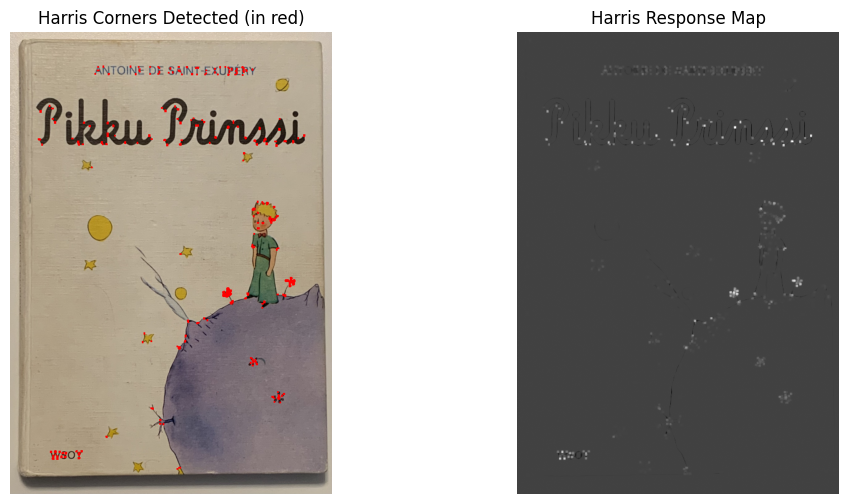

In [14]:
# Cell 1: Harris Corner Detection
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

# Load and preprocess image
img = cv.imread('resources/ref1.png')
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
gray = cv.cvtColor(img, cv.COLOR_RGB2GRAY)
gray = np.float32(gray)

# Harris corner detection
# Adjust these parameters for better results:
# blockSize: neighborhood size (try 2, 3, 5)
# ksize: Sobel aperture (usually 3)
# k: Harris parameter (0.04 - 0.1 often works well)
corners = cv.cornerHarris(gray, blockSize=3, ksize=3, k=0.1) # Detect corners: blockSize=2 (neighborhood), ksize=3 (Sobel), k=0.04 (Harris parameter)

# Dilate for marking the corners
vis_corners = cv.dilate(corners, None) # Dilate corner points to enhance visibility

# Mark strong corners in red
threshold = 0.1 * vis_corners.max()
img[vis_corners > threshold] = [255, 0, 0]  # Red corners

# Display result

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(img)
axes[0].set_title("Harris Corners Detected (in red)")
axes[0].axis('off')

axes[1].imshow(vis_corners, cmap='gray')
axes[1].set_title("Harris Response Map")
axes[1].axis('off')

plt.show()


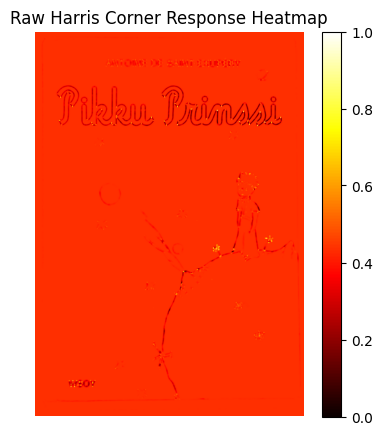

In [15]:
# Cell 2: Visualize the raw Harris response (optional)
# Replace img with corners to see the response heatmap
response_vis = corners.copy()
response_vis = (response_vis - response_vis.min()) / (response_vis.max() - response_vis.min())

plt.figure(figsize=(5, 5))
plt.imshow(response_vis, cmap='hot')
plt.title("Raw Harris Corner Response Heatmap")
plt.colorbar()
plt.axis('off')
plt.show()

## SIFT (Scale-Invariant Feature Transform)

Unlike Harris corners, which are rotation-invariant but not scale-invariant (a corner might look like an edge if zoomed in), **SIFT** features are designed to be invariant to both scale and rotation.

### Scale Invariance
SIFT searches for features across multiple scales (image pyramids), allowing it to match the same feature whether the object is seen from close up or far away.

### `sift.detectAndCompute`
This function identifies interest points and computes their fingerprints:
-   **Keypoints**: The `(x, y)` location, scale (size), and orientation of the feature.
-   **Descriptors**: A 128-dimensional vector describing the local image texture around the keypoint, used for matching.

### Visualizing SIFT Features
When drawing keypoints:
-   **Circle Size**: Represents the **scale** at which the feature was detected.
-   **Radius Direction**: Indicates the dominant **orientation** of the feature.


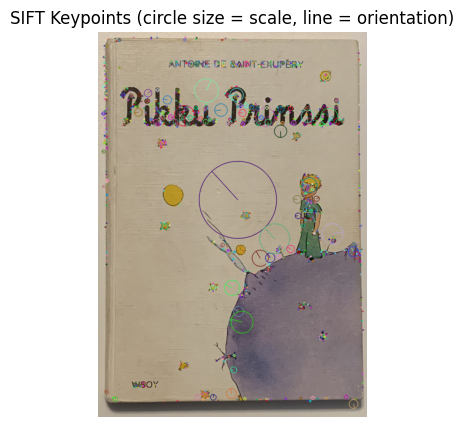

In [16]:
# Cell 3: SIFT Feature Detection on ref1.png
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

# Load image
img1 = cv.imread('resources/ref1.png')
img1 = cv.cvtColor(img1, cv.COLOR_BGR2RGB)

# Create SIFT detector
sift = cv.SIFT_create()

# Detect keypoints (with rich visualization)
kp1 = sift.detect(img1, None)
kp1_img = cv.drawKeypoints(img1, kp1, None, flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS) # Flags=DRAW_RICH_KEYPOINTS shows scale (size) and orientation

# Display
fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(kp1_img)
ax.set_title("SIFT Keypoints (circle size = scale, line = orientation)")
plt.axis('off')
plt.show()


## Feature Matching with Brute-Force

We match features between two images (e.g., a reference object and a rotated scene) by comparing their descriptors.

### Brute-Force Matcher (BFMatcher)
The BFMatcher picks a descriptor from the first set and matches it with *every* descriptor in the second set, calculating the distance.
-   **L2 Norm (Euclidean Distance)**: Used for SIFT descriptors (float-based). Closer distance = better match.

### Sorting & Display
-   **Start by Distance**: Matches are sorted so that those with the smallest Euclidean distance (best matches) appear first.
-   **Top 20**: We visualize only the top matches to reduce clutter and focus on the strongest correspondences.


Number of keypoints in ref1.png: 1074
Number of keypoints in rot1.png: 1252
Descriptor shape: (1074, 128) → 128-dimensional vector per keypoint


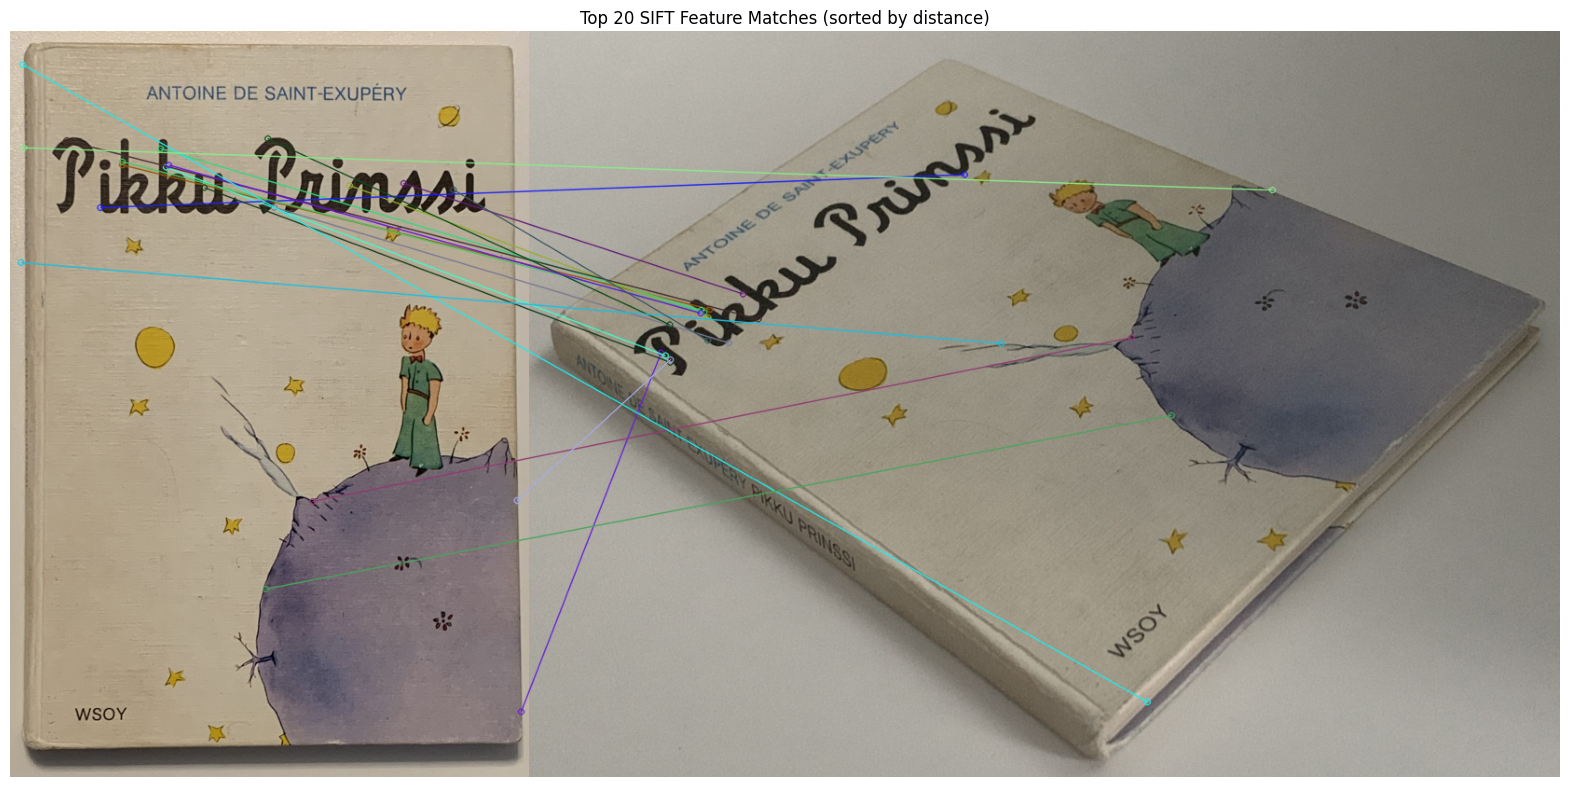

In [5]:
# Cell 4: SIFT Feature Matching between ref1.png and rot1.png
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

# Load both images
img1 = cv.imread('resources/ref1.png')
img1 = cv.cvtColor(img1, cv.COLOR_BGR2RGB)

img2 = cv.imread('resources/rot1.png')
img2 = cv.cvtColor(img2, cv.COLOR_BGR2RGB)

# Initialize SIFT
sift = cv.SIFT_create()

# Detect keypoints and compute descriptors
kp1, des1 = sift.detectAndCompute(img1, None) # Detect keypoints (loc/scale) & compute 128-d descriptors
kp2, des2 = sift.detectAndCompute(img2, None) # Detect keypoints (loc/scale) & compute 128-d descriptors

print(f"Number of keypoints in ref1.png: {len(kp1)}")
print(f"Number of keypoints in rot1.png: {len(kp2)}")
print(f"Descriptor shape: {des1.shape} → 128-dimensional vector per keypoint")

# Brute Force Matcher with L2 norm
bf = cv.BFMatcher(cv.NORM_L2, crossCheck=True) # BFMatcher with default params (L2 norm) for SIFT float descriptors
matches = bf.match(des1, des2)

# Sort matches by distance (lower = better)
matches = sorted(matches, key=lambda x: x.distance) # Sort matches by distance (best matches first)

# Draw top 20 best matches
match_img = cv.drawMatches(img1, kp1, img2, kp2, matches[:20], None,
                           flags=cv.DRAW_MATCHES_FLAGS_NOT_DRAW_SINGLE_POINTS)

# Display
fig, ax = plt.subplots(figsize=(20, 10))
ax.imshow(match_img)
ax.set_title("Top 20 SIFT Feature Matches (sorted by distance)") # Sort matches by distance (best matches first)
plt.axis('off')
plt.show()


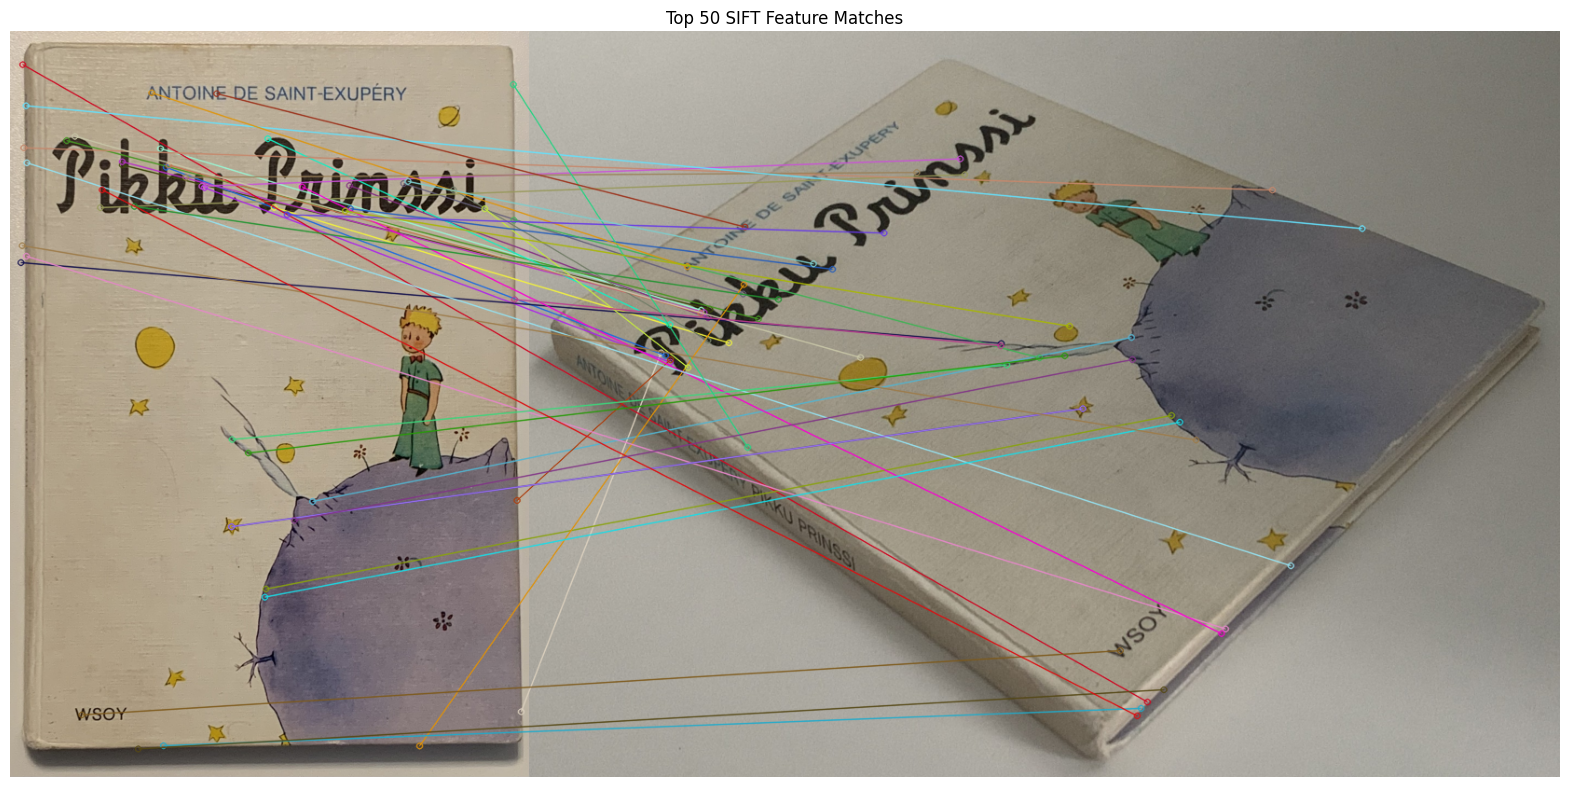

In [6]:
# Cell 5: Optional - Show more matches (e.g., top 50) or all
# Change [:20] to [:50] or remove slicing to see all matches
# Warning: too many matches may clutter the image

# Example: Show top 50
match_img_all = cv.drawMatches(img1, kp1, img2, kp2, matches[:50], None,
                               flags=cv.DRAW_MATCHES_FLAGS_NOT_DRAW_SINGLE_POINTS)

fig, ax = plt.subplots(figsize=(20, 10))
ax.imshow(match_img_all)
ax.set_title("Top 50 SIFT Feature Matches")
plt.axis('off')
plt.show()

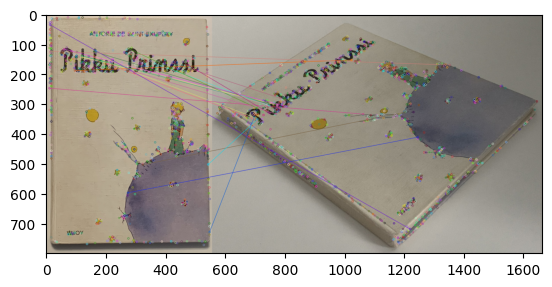

In [8]:
sift = cv.SIFT_create()
kp1, des1 = sift.detectAndCompute(img1, None) # Detect keypoints (loc/scale) & compute 128-d descriptors
kp2, des2 = sift.detectAndCompute(img2, None) # Detect keypoints (loc/scale) & compute 128-d descriptors
bf = cv.BFMatcher(cv.NORM_L2, crossCheck=True) # BFMatcher with default params (L2 norm) for SIFT float descriptors
matches = bf.match(des1, des2)
matches = sorted(matches, key=lambda x:x.distance) # Sort matches by distance (best matches first)
res = cv.drawMatches(img1, kp1, img2, kp2, matches[:20], None)
plt.imshow(res)
